In [1]:
from bs4 import BeautifulSoup as bs
from bs4.element import Comment
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
from geopandas import GeoDataFrame
from shapely.geometry import Point


#Data Question 4: Web Scraping Earthquake Data
##Part 1:

Nate Silver discusses the difficulty of predicting earthquakes in The Signal and the Noise. Nevertheless, we will try to identify some patterns by analyzing the deadly earthquakes that have occurred since 1900.

To start, read the table of earthquakes from https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900 using the requests and/or beautifulsoup library and load it to a pandas dataframe. You will need to do some data cleaning before you can proceed.

In [2]:
url='https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900'

In [3]:
earthq_resp=requests.get(url).content

In [4]:
#print(earthq_resp.status_code)

In [5]:
# parse data from the html into a beautifulsoup object
earthq_soup=bs(earthq_resp, 'html.parser')
earthq_table=earthq_soup.find('table',{'class':"wikitable"})

In [6]:
earthq_table 

<table class="sortable wikitable">
<tbody><tr bgcolor="#CCCCCC">
<th width="22%">Origin (<a class="mw-redirect" href="/wiki/UTC" title="UTC">UTC</a>)</th>
<th width="33%">Present-day country and link to Wikipedia article</th>
<th width="10%"><a href="/wiki/Latitude" title="Latitude">Lat</a></th>
<th width="10%"><a href="/wiki/Longitude" title="Longitude">Long</a></th>
<th width="8%">Depth (<a class="mw-redirect" href="/wiki/Km" title="Km">km</a>)</th>
<th width="6%">Magnitude</th>
<th width="9%">Secondary Effects</th>
<th width="10%">PDE Shaking Deaths</th>
<th width="10%">PDE Total Deaths</th>
<th width="10%">Utsu Total Deaths</th>
<th width="10%">EM-DAT Total Deaths</th>
<th width="12%">Other Source Deaths
</th></tr>
<tr>
<td>1900-05-11 17:23</td>
<td>Japan</td>
<td>38.700</td>
<td>141.100</td>
<td>5</td>
<td>7.0 <a href="/wiki/Seismic_magnitude_scales#Mjma" title="Seismic magnitude scales"><span class="rt-commentedText" title="JMA mag.">M<sub>JMA</sub></span></a></td>
<td></td>
<td>

In [7]:
#convert html to list of data frame object
earthq_df=pd.read_html(str(earthq_table))
# convert list to dataframe
earthq_df=pd.DataFrame(earthq_df[0])

In [8]:
earthq_df.head(60)

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9 Muk,NaN,NaN,NaN,140.0,NaN,NaN
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4 Muk,NaN,NaN,NaN,4.0,NaN,NaN
5,1901-08-09 09:23,Japan,40.500,142.500,35,7.2 Mw,T,NaN,NaN,NaN,NaN,NaN
6,1901-11-15 20:15,New Zealand (see 1901 Cheviot earthquake),-43.000,173.000,0,6.8 Ms,NaN,NaN,NaN,1.0,NaN,NaN
7,1902-01-30 14:01,Japan,40.500,141.300,35,6.9 Ms,NaN,NaN,NaN,1.0,NaN,NaN
8,1902-02-13 09:39,Azerbaijan,40.700,48.600,15,6.9 Muk,NaN,NaN,NaN,86.0,NaN,NaN
9,1902-03-09 07:46,Turkey,40.700,33.600,NaN,5.5 Muk,NaN,NaN,NaN,4.0,NaN,NaN


##Data cleaning tasks include:

- Replace empty strings with NaN
- Remove the footnotes from the 'Other Source Deaths' column
- Convert Magnitude to a numeric type. For this portion, you can ignore differences in seismic magnitude scales.
- Correct number of deaths when there is more than one value. When there is more than one value given, choose the largest.
- Create a new column ('deaths') that evaluates the four total-death columns ('PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', and 'Other Source Deaths') and populates the new column with the highest value.
- Explore the data in terms of when and where earthquakes occurred and how severe they were (magnitude, deaths, secondary effects).

In [9]:
earthq_df=earthq_df.replace(r'^\s*$', np.NaN, regex=True)

In [10]:
earthq_df. head(60)  

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9 Muk,NaN,NaN,NaN,140.0,NaN,NaN
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4 Muk,NaN,NaN,NaN,4.0,NaN,NaN
5,1901-08-09 09:23,Japan,40.500,142.500,35,7.2 Mw,T,NaN,NaN,NaN,NaN,NaN
6,1901-11-15 20:15,New Zealand (see 1901 Cheviot earthquake),-43.000,173.000,0,6.8 Ms,NaN,NaN,NaN,1.0,NaN,NaN
7,1902-01-30 14:01,Japan,40.500,141.300,35,6.9 Ms,NaN,NaN,NaN,1.0,NaN,NaN
8,1902-02-13 09:39,Azerbaijan,40.700,48.600,15,6.9 Muk,NaN,NaN,NaN,86.0,NaN,NaN
9,1902-03-09 07:46,Turkey,40.700,33.600,NaN,5.5 Muk,NaN,NaN,NaN,4.0,NaN,NaN


In [11]:
earthq_df. tail(60)

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
1280,2007-01-21 11:27,Indonesia,1.065,126.282,22,7.5 Mw,NaN,3.0,4.0,NaN,NaN,NaN
1281,2007-03-06 03:49,Indonesia (see March 2007 Sumatra earthquakes),-0.480,100.470,19.3,6.4 Mw,NaN,67.0,67.0,NaN,67,NaN
1282,2007-03-25 00:41,Japan (see 2007 Noto earthquake),37.340,136.540,8,6.7 Mw,T,1.0,1.0,NaN,1,NaN
1283,2007-04-01 20:39,Solomon Islands (see 2007 Solomon Islands eart...,-8.430,157.060,10,8.1 Mw,"T,L",0.0,54.0,NaN,NaN,NaN
1284,2007-04-21 17:53,Chile (see 2007 Aysén Fjord earthquake),-45.240,-72.670,36.7,6.2 Mw,"T,L",0.0,10.0,NaN,10,NaN
1285,2007-06-02 21:34,China,23.020,101.010,5,6.1 Mw,L,3.0,3.0,NaN,3,NaN
1286,2007-07-16 01:13,Japan (see 2007 Chūetsu offshore earthquake),37.520,138.460,12,6.6 Mw,"T,L",9.0,9.0,NaN,9,NaN
1287,2007-07-21 22:44,Tajikistan,38.936,70.485,10,5.2 Mw,L,3.0,12.0,NaN,11,NaN
1288,2007-08-02 02:37,Russian Federation,47.110,141.810,5,6.2 Mw,T,2.0,2.0,NaN,2,NaN
1289,2007-08-15 23:40,Peru (see 2007 Peru earthquake),-13.380,-76.610,39,8.0 Mw,L,514.0,514.0,NaN,519,NaN


In [12]:
earthq_df['OtherSourceDeathsClean1']=earthq_df['Other Source Deaths'].str.extract('\s*(\d+\,*\d*)\D*').replace(',','')

In [13]:
earthq_df['OtherSourceDeathsClean1']=earthq_df['OtherSourceDeathsClean1'].str.replace(',','').astype('float')

In [14]:
earthq_df['Other Source Deaths'].unique()

array([nan, '3500', '8000+', '46', '164[6]', '1500[6]', '105000', '1404',
       '1', '120', '200', '380', '2041', '33[8]', '45000[9]', '2489[10]',
       '26271[11] 26000[12]', '68', '231000*[13] 283000*[14] 227898*[15]',
       '41', '60[16]', '215', '34', '295', '79', '189', '1115',
       '222,517[17]', '521[19]', '42', '2698', '185', '15894[20]', '150+',
       '111+', '601 (as of October 30, 2011)'], dtype=object)

In [15]:
earthq_df['OtherSourceDeathsClean2']=earthq_df['Other Source Deaths'].str.extract(r'\*+\[+\d+\]+\s+(\d+)\*+\[+\d+\]+\s+').astype('float')

In [16]:
earthq_df['OtherSourceDeathsClean3']=earthq_df['Other Source Deaths'].str.extract(r'\*+\[+\d+\]+\s+\d+\*+\[+\d+\]+\s+(\d+)\*+\[\d+\]+').astype('float')

In [17]:
earthq_df['OtherSourceDeathsClean2'].unique()

array([    nan, 283000.])

In [18]:
earthq_df['OtherSourceDeathsClean3'].unique()

array([    nan, 227898.])

In [19]:
earthq_df['OtherSourceDeathsClean'] = earthq_df[[
    'OtherSourceDeathsClean1','OtherSourceDeathsClean2','OtherSourceDeathsClean3']].max(axis=1).astype('float')

In [20]:
earthq_df['OtherSourceDeathsClean'].unique()

array([        nan, 3.50000e+03, 8.00000e+03, 4.60000e+01, 1.64000e+02,
       1.50000e+03, 1.05000e+05, 1.40400e+03, 1.00000e+00, 1.20000e+02,
       2.00000e+02, 3.80000e+02, 2.04100e+03, 3.30000e+01, 4.50000e+04,
       2.48900e+03, 2.62710e+04, 6.80000e+01, 2.83000e+05, 4.10000e+01,
       6.00000e+01, 2.15000e+02, 3.40000e+01, 2.95000e+02, 7.90000e+01,
       1.89000e+02, 1.11500e+03, 2.22517e+05, 5.21000e+02, 4.20000e+01,
       2.69800e+03, 1.85000e+02, 1.58940e+04, 1.50000e+02, 1.11000e+02,
       6.01000e+02])

In [41]:
earthq_df['Magnitude (RS)']=earthq_df['Magnitude'].str.extract(r'(\d+\.\d+)\w*\D*\d*\D*').astype('float')

In [22]:
earthq_df['Magnitude_type']=earthq_df['Magnitude'].str.extract(r'\d+\.\d+\s*(\w+)')

In [23]:
earthq_df.head(60)

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths,OtherSourceDeathsClean1,OtherSourceDeathsClean2,OtherSourceDeathsClean3,OtherSourceDeathsClean,Earth Quack Magnitude,Magnitude_type
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,MJMA
1,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9 Muk,NaN,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,NaN,5.9,Muk
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.7,Mw
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,Ms
4,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4 Muk,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,6.4,Muk
5,1901-08-09 09:23,Japan,40.500,142.500,35,7.2 Mw,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2,Mw
6,1901-11-15 20:15,New Zealand (see 1901 Cheviot earthquake),-43.000,173.000,0,6.8 Ms,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6.8,Ms
7,1902-01-30 14:01,Japan,40.500,141.300,35,6.9 Ms,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6.9,Ms
8,1902-02-13 09:39,Azerbaijan,40.700,48.600,15,6.9 Muk,NaN,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,NaN,6.9,Muk
9,1902-03-09 07:46,Turkey,40.700,33.600,NaN,5.5 Muk,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,5.5,Muk


In [24]:
earthq_df.tail(60)

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths,OtherSourceDeathsClean1,OtherSourceDeathsClean2,OtherSourceDeathsClean3,OtherSourceDeathsClean,Earth Quack Magnitude,Magnitude_type
1280,2007-01-21 11:27,Indonesia,1.065,126.282,22,7.5 Mw,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.5,Mw
1281,2007-03-06 03:49,Indonesia (see March 2007 Sumatra earthquakes),-0.480,100.470,19.3,6.4 Mw,NaN,67.0,67.0,NaN,67,NaN,NaN,NaN,NaN,NaN,6.4,Mw
1282,2007-03-25 00:41,Japan (see 2007 Noto earthquake),37.340,136.540,8,6.7 Mw,T,1.0,1.0,NaN,1,NaN,NaN,NaN,NaN,NaN,6.7,Mw
1283,2007-04-01 20:39,Solomon Islands (see 2007 Solomon Islands eart...,-8.430,157.060,10,8.1 Mw,"T,L",0.0,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.1,Mw
1284,2007-04-21 17:53,Chile (see 2007 Aysén Fjord earthquake),-45.240,-72.670,36.7,6.2 Mw,"T,L",0.0,10.0,NaN,10,NaN,NaN,NaN,NaN,NaN,6.2,Mw
1285,2007-06-02 21:34,China,23.020,101.010,5,6.1 Mw,L,3.0,3.0,NaN,3,NaN,NaN,NaN,NaN,NaN,6.1,Mw
1286,2007-07-16 01:13,Japan (see 2007 Chūetsu offshore earthquake),37.520,138.460,12,6.6 Mw,"T,L",9.0,9.0,NaN,9,NaN,NaN,NaN,NaN,NaN,6.6,Mw
1287,2007-07-21 22:44,Tajikistan,38.936,70.485,10,5.2 Mw,L,3.0,12.0,NaN,11,NaN,NaN,NaN,NaN,NaN,5.2,Mw
1288,2007-08-02 02:37,Russian Federation,47.110,141.810,5,6.2 Mw,T,2.0,2.0,NaN,2,NaN,NaN,NaN,NaN,NaN,6.2,Mw
1289,2007-08-15 23:40,Peru (see 2007 Peru earthquake),-13.380,-76.610,39,8.0 Mw,L,514.0,514.0,NaN,519,NaN,NaN,NaN,NaN,NaN,8.0,Mw


In [25]:
earthq_df['EM-DAT Total Deaths'].unique()

array([nan, '2000', '20000', '2500', '400', '12000', '75000', '923', '20',
       '29980', '1800', '10000', '100', '116', '180000', '1000', '5000',
       '143000', '2925', '200000', '107', '3300', '500', '0', '36', '256',
       '6', '3008', '6000', '3410', '60000', '9', '149', '30000', '32962',
       '249', '980', '200', '3000', '213', '1083', '2824', '3959', '998',
       '1961', '4000', '165', '73', '1400', '233', '27', '5131', '110000',
       '8', '437', '1500', '30', '14', '1200', '455', '7', '13', '1250',
       '39', '53', '160', '28', '191', '57', '131', '4', '25', '23', '38',
       '128', '10[7]|', '80', '2394', '120', '61', '54', '183', '240',
       '177', '19', '47', '11', '271', '29', '15', '41', '24', '150',
       '1086', '66794', '176', '65', '878', '85', '5057', '17', '78',
       '2385', '1', '23000', '50', '2', '10', '922', '420', '573',
       '242000', '16', '3840', '1641', '167', '352', '3', '185', '589',
       '21', '25000', '45', '5', '121', '34', '26', '35

In [26]:
earthq_df['EM-DAT_TotalDeathsClean']= earthq_df['EM-DAT Total Deaths'].str.extract(r'(\d+)\s*\D*').astype('float')


In [27]:
earthq_df['Total_deaths'] = earthq_df[[
    'PDE Shaking Deaths','PDE Total Deaths','Utsu Total Deaths','EM-DAT_TotalDeathsClean', 'OtherSourceDeathsClean'
]].sum(axis=1)

In [28]:
earthq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 20 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Origin (UTC)                                       1340 non-null   object 
 1   Present-day country and link to Wikipedia article  1340 non-null   object 
 2   Lat                                                1325 non-null   object 
 3   Long                                               1325 non-null   object 
 4   Depth (km)                                         1250 non-null   object 
 5   Magnitude                                          1339 non-null   object 
 6   Secondary Effects                                  373 non-null    object 
 7   PDE Shaking Deaths                                 738 non-null    float64
 8   PDE Total Deaths                                   749 non-null    float64
 9   Utsu Tot

In [29]:
earthq_df['country']=earthq_df['Present-day country and link to Wikipedia article'].str.extract(r'(\w+\s*\w*)\s*\(*')

In [30]:
earthq_df['Secondary Effects 1']=earthq_df['Secondary Effects'].str.extract(r'(\w+)\,*')

In [31]:
earthq_df['Secondary Effects 2']=earthq_df['Secondary Effects'].str.extract(r'\w+\,+(\w+)\,*')

In [32]:
earthq_df['Secondary Effects 3']=earthq_df['Secondary Effects'].str.extract(r'\w+\,+\w+\,(\w+)')

In [33]:
earthq_df['Secondary Effects 2'].unique()

array([nan, 'F', 'L', 'Lq', 'LF'], dtype=object)

In [34]:
earthq_df['Depth (km)']=earthq_df['Depth (km)'].str.replace('?', 'NaN')
#=earthq_df['Depth (km)'].astype('float')

In [35]:
earthq_df['Depth (km)']=earthq_df['Depth (km)'].astype('float')

In [54]:
#earthq_df.query('Earth Quack Magnitude > 5.0 or (Earth Quack Magnitude< 5.0 and `Secondary Effects` == "L" and 'Total_deaths' > 10)', inplace = True)

earthq_df=earthq_df[(earthq_df['Magnitude (RS)'] > 5.0) & (earthq_df['Total_deaths'] > 10)]

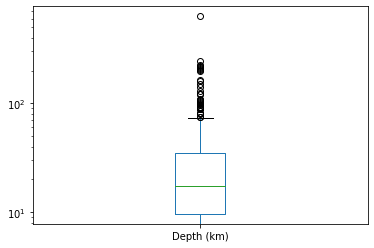

In [55]:
ax=earthq_df['Depth (km)'].plot.box()
ax.figsize=(20, 30)
plt.yscale('log')

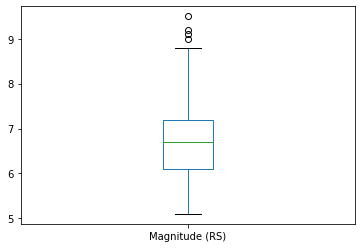

In [56]:
ax=earthq_df['Magnitude (RS)'].plot.box()
ax.figsize=(20, 30)

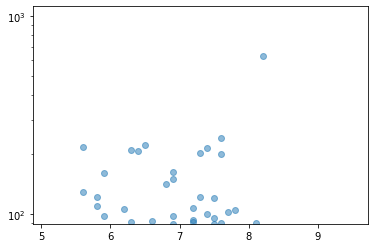

In [57]:
plt.scatter(earthq_df['Magnitude (RS)'],earthq_df['Depth (km)'], alpha=0.5)
plt.yscale('log')


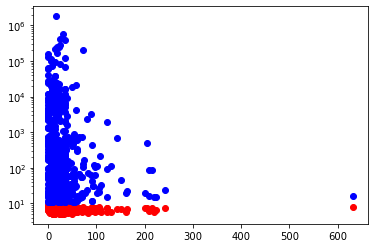

In [58]:
plt.scatter(earthq_df['Depth (km)'], earthq_df['Magnitude (RS)'],color='red')
plt.scatter(earthq_df['Depth (km)'], earthq_df['Total_deaths'] ,color= 'blue')
plt.yscale('log')

In [59]:
earthq_df['Log Depth (km)'] = np.log(earthq_df['Depth (km)'])
earthq_df['Log Deaths'] = np.log(earthq_df['Total_deaths']+1)

/Users/turik1/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/Users/turik1/opt/anaconda3/lib/python3.8/site-packages/numpy/core/function_base.py:153: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/turik1/opt/anaconda3/lib/python3.8/site-packages/numpy/core/function_base.py:163: RuntimeWarning: invalid value encountered in add
  y += start
/Users/turik1/opt/anaconda3/lib/python3.8/site-packages/numpy/linalg/linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


Text(0.5, 1.0, 'Scatter Plot with Linear fit')

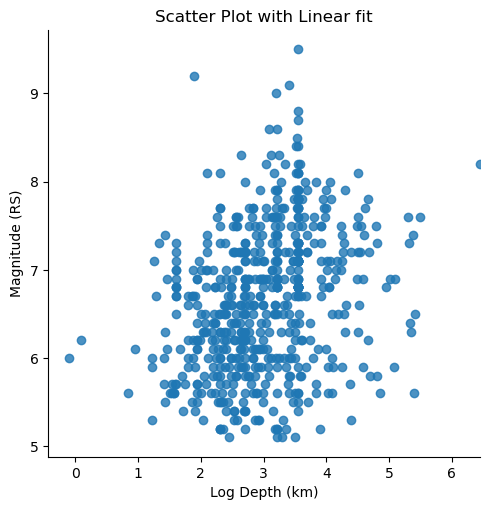

In [68]:
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='Log Depth (km)', y='Magnitude (RS)', data=earthq_df)
plt.title("Scatter Plot with Linear fit")

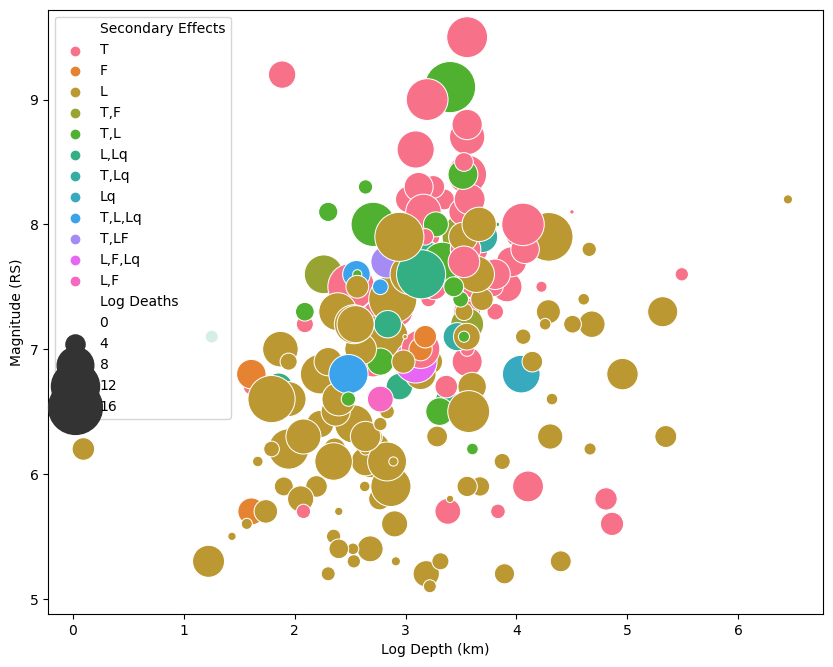

In [84]:
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.scatterplot(x='Log Depth (km)', y='Magnitude (RS)', hue='Secondary Effects', size='Log Deaths', sizes=(0, 1500), data=earthq_df)




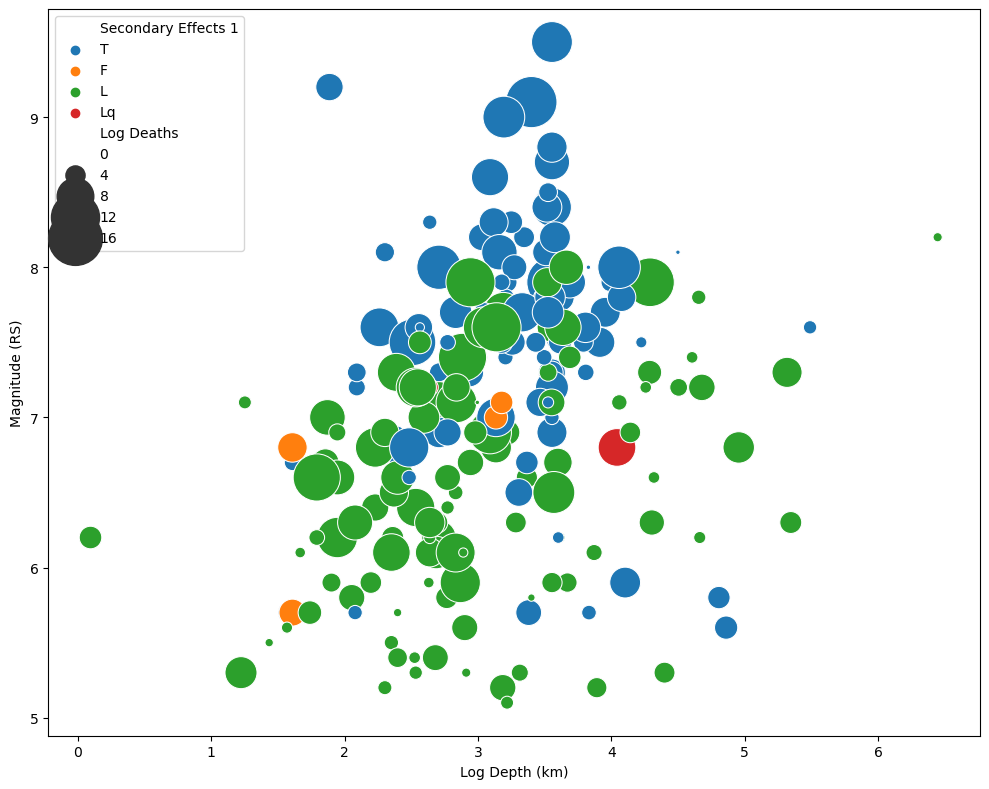

In [85]:
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.scatterplot(x='Log Depth (km)', y='Magnitude (RS)',  hue='Secondary Effects 1', sizes=(0, 1500), size='Log Deaths' , data=earthq_df)

plt.tight_layout()

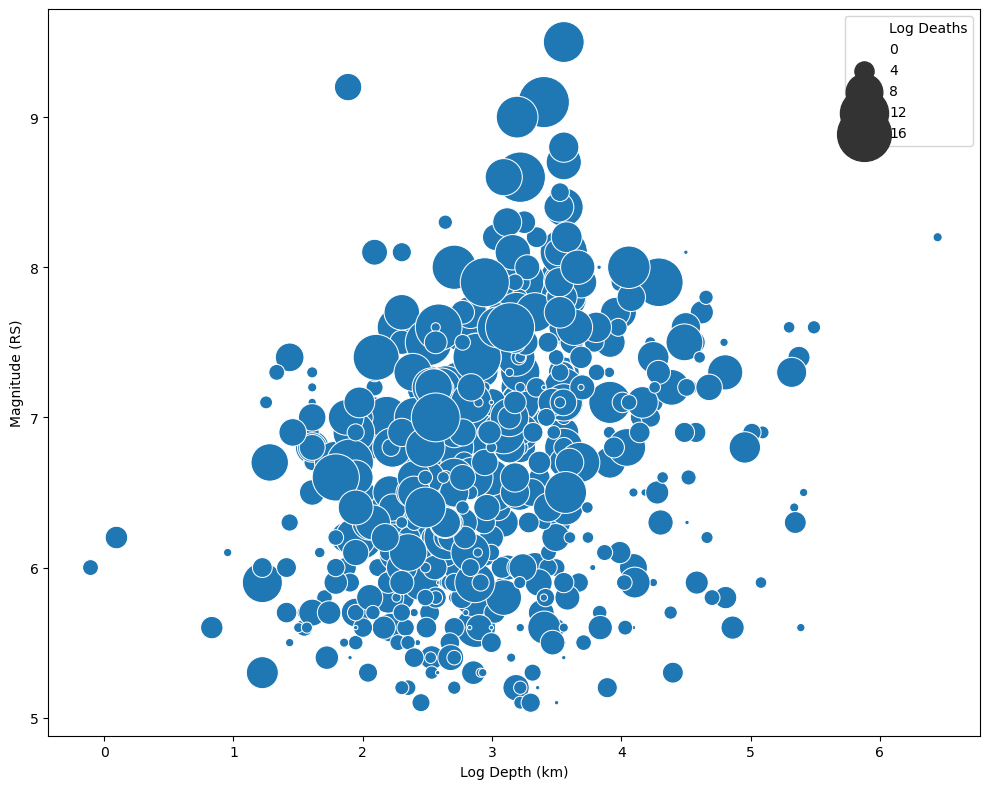

In [86]:
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.scatterplot(x='Log Depth (km)', y='Magnitude (RS)',  sizes=(0, 1500), size='Log Deaths' , data=earthq_df)

plt.tight_layout()


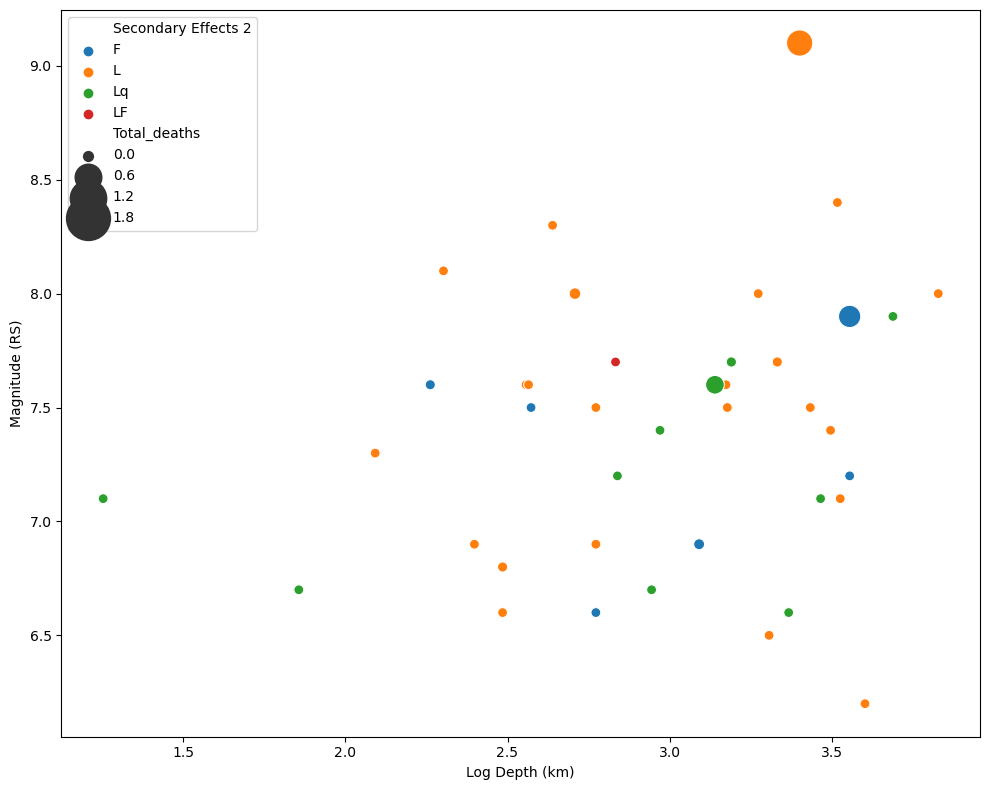

In [79]:
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.scatterplot(x='Log Depth (km)', y='Magnitude (RS)', hue='Secondary Effects 2', size='Total_deaths', sizes=(50, 1000), data=earthq_df)

# Put the legend out of the figure
#plt.legend(bbox_to_anchor=(1.01, 0.54),  borderaxespad=0.)

plt.tight_layout()



In [80]:
earthq_df['Total_deaths'].agg(['min','mean', 'max'])

min     1.100000e+01
mean    9.411822e+03
max     1.795274e+06
Name: Total_deaths, dtype: float64

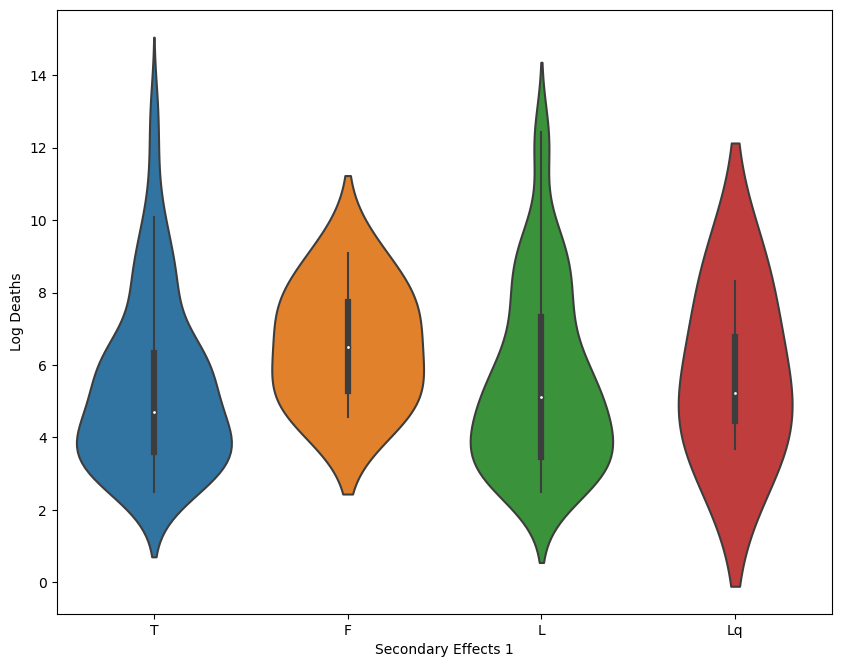

In [83]:
ax = sns.violinplot(x="Secondary Effects 1", y="Log Deaths", data=earthq_df)